In [107]:
import oracledb
import cx_Oracle
from datetime import datetime, timedelta, time, date
import numpy as np
from scipy.interpolate import splrep, splev
import csv
import pickle
from pathlib import Path
import os


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV, MultiTaskLasso, MultiTaskElasticNetCV, MultiTaskElasticNet, TheilSenRegressor, ElasticNet, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.linear_model import HuberRegressor, RANSACRegressor
from sklearn.cross_decomposition import PLSRegression, PLSCanonical

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.utils import shuffle


from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import median_absolute_error


from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

from scipy.fft import dctn, idctn

from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [106]:
# Коды моделей
models = {
    'gfs': 4,
    'icon': 5,
    'orv': 100,
}

#### Функция чтения данных из БД

In [177]:
def read_temperature_from_db(forecast_model, start_date, finish_date):
    model_id = models[forecast_model]
    
    try:
        cx_Oracle.init_oracle_client(lib_dir=r"F:\ruslan\dev\oracle\instantclient_19_9")
    except:
        pass
    
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    /* SELECT to_char(DATAS, 'YYYY-MM-DD'), ADVANCE_TIME,  TEMP */
    SELECT DATAS, ADVANCE_TIME,  TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = :model_id
          AND ADVANCE_TIME between 0 and 48
          /*AND datas >= '01-08-2022'*/
          /*AND datas between '01-08-2022' and '31-12-2022'*/
          AND datas >= :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    model_id=model_id,                 
    start_date=start_date
    )
    
    date = None
    forecast_arr = []
    f_row = [] 
    for c in cursor_nwp:
        # Нова дата - создаем новую строку данных
        if date != c[0]:
            # Если дата пройдена, присоединить строку данных f_row к массиву forecast_arr
            if date:
                forecast_arr.append(f_row) 
            # Инициализируем следующую дату и строку данных
            date = c[0]       
            f_row = [None for _ in range(50)]
            f_row[0] = c[0] # Дату c[0] записать в позицию 0
        # В позицию списка, равную заблаговременности c[1] записать температуру c[2]
        f_row[c[1] + 1] = c[2]
    # Присоединить последнюю строку данных f_row к массиву forecast_arr
    forecast_arr.append(f_row)        
    # print(*forecast_arr, sep='\n')
    conn_nwp.close()
    
    
    conn_gts = cx_Oracle.connect(user="cligts", password="belorgmc", dsn="192.168.211.173/clidb")
    cursor_gts = conn_gts.cursor()
    
    cursor_gts.execute(
    """
    SELECT DATE_OBS, TEMPDB
    FROM gts.synop
    WHERE 
      /*date_obs >= '01-08-2022'*/
      /* date_obs between '01-08-2022' and '31-12-2022' */
      date_obs >= :start_date
      AND station_id = '26850'
    """,
    start_date=start_date
    )
    
    gts_rows = cursor_gts.fetchall()
    # for c in gts_rows:
    #     print(c)
    
    conn_gts.close()
    
    
    # Формирование y - значений фактической температуры, соответствующих каждой дате на 48 часов вперед
    # Поиск каждой совпадающей строки по дате и сроку 00
    start = 0
    fact_arr = []
    forecast_X = []
    td48 = timedelta(hours=48)
    for f in forecast_arr:
        date_nwp = f[0]
        # Прервать выполнение, если от даты прогноза до текущего момента 
        # прошло менее или ровно 48 часов, т.к. не будет соответствующих фактических данных
        if datetime.today() - date_nwp <= td48:
            print(datetime.today() - date_nwp)
            print(f'Прервано - для даты {date_nwp} не хватит фактических данных!')
            break
        # print('NWP Date:', date_nwp)
        # print('GTS start:', start)
        for i, g in enumerate(gts_rows[start:]):
            if g[0] == f[0]: # Строка найдена
                # print(f[0])
                start += i
                forecast_X.append(f)
                break
        # Инициализировать строку данных для фактической температуры 17 значений
        g_row = [None for _ in range(18)]
        g_row[0] = g[0]
        # print('GTS Date:', g[0])
        for j in range(17):
            gts_date = gts_rows[start + j][0]
            gts_temperature = gts_rows[start + j][1]
            td = gts_date - date_nwp
            # print('Time delta for g_row:', td, 'Temper;', gts_temperature)
            # В пределах 48 часов
            if td <= td48:
                td_hours = int(td.days * 24 + td.seconds / 3600)
                # print('td_hours', td_hours)
                cell = td_hours // 3
                # print('cell', cell)
                g_row[cell + 1] = gts_temperature
            else:
                # start += i #!!!!
                print('BREAK!!!')
                break
        fact_arr.append(g_row)
        # print(g_row)
    
    # print(*forecast_arr, sep='\n')
    # print('Fact:')
    # print(*fact_arr, sep='\n')
    
    fact_y = fact_arr
    
    
    
    # Проверка на пропущенные значения (None)
    damaged_rows = set()
    
    for i, (x, y) in enumerate(zip(forecast_X, fact_y)):
        
        if x[0] != y[0]:
            damaged_rows.add(i)
            print('Damaged dates:', x[0], y[0])
        
        damage_x = False
        for xi in x: 
            if xi is None:
                damage_x = True
                break
        if damage_x:
            damaged_rows.add(i)
            print('x', x)
        
        damage_y = False
        for yi in y: 
            if yi is None:
                damage_y = True
                break
        if damage_y:
            damaged_rows.add(i)
            print('y', y)
    
    damaged_rows = sorted(list(damaged_rows), reverse=True)
    print('damaged_rows:', damaged_rows)
    
    # Удаление строк с пропусками
    for i in damaged_rows:
        forecast_X.pop(i)
        fact_y.pop(i)
    print('forecast_X, fact_y len:', len(forecast_X), len(fact_y))
    
    return forecast_X, fact_y

In [179]:
forecast, fact = read_temperature_from_db('icon', '01-11-2022', '')

1 day, 15:23:21.959933
Прервано - для даты 2024-02-14 00:00:00 не хватит фактических данных!
x [datetime.datetime(2022, 12, 12, 0, 0), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
y [datetime.datetime(2023, 9, 3, 0, 0), 9.2, 8.9, 14.3, 21.0, 22.5, 19.6, 15.2, 10.8, 9.0, 7.2, 19.7, 20.7, 21.8, None, None, None, None]
y [datetime.datetime(2023, 9, 4, 0, 0), 9.0, 7.2, 19.7, 20.7, 22.3, 21.9, 14.7, 10.0, 7.8, 6.1, 15.8, None, None, None, None, None, None]
damaged_rows: [266, 265, 41]
forecast_X, fact_y len: 426 426


#### Функция записи датасетов в файлы CSV

In [128]:
def write_csv(forecast_model, forecast, fact, z=48, append=True):
    model_id = models[forecast_model]
    # Проверить, есть ли каталог для модели, если нет, то содать его
    dir_path = f'data/{forecast_model}'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, mode=0o777, exist_ok=True)
    
    mode = 'at' if append else 'wt'
    # Запись прогноза
    forecast_header = ['date_term'] + [f'z_{x}' for x in range(z + 1)]
    with open(f'{dir_path}/forecast_{forecast_model}.csv', mode, newline='') as f_forecast:
        forecast_writer = csv.writer(f_forecast, delimiter=';')
        if mode == 'wt':
            forecast_writer.writerow(forecast_header)
        forecast_writer.writerows(forecast)
    # Запись факта
    fact_header = ['date'] + [f't_{x % 24}' for x in range(0, z + 1, 3)]
    with open(f'{dir_path}/fact.csv', mode, newline='') as f_fact:
        fact_writer = csv.writer(f_fact, delimiter=';')
        if mode == 'wt':
            fact_writer.writerow(fact_header)
        fact_writer.writerows(fact)

    # Запись файла с датой последних данных в датасетах
    date_time = forecast[-1][0]
    write_last_date_file(forecast_model, date_time)

#### Функция записи файла с датой последних данных в датасетах

In [129]:
def write_last_date_file(forecast_model, date_time):
    with open(f'data/{forecast_model}/last_date.txt', 'wt') as f:
        f.write(str(date_time))

#### Функция чтения файла с датой последних данных в датасетах

In [135]:
def read_last_date_file(forecast_model):
    with open(f'data/{forecast_model}/last_date.txt', 'rt') as f:
        date_time_str = f.readline()
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    return date_time

In [137]:
read_last_date_file('gfs')

datetime.datetime(2024, 2, 13, 0, 0)

## Функция создания на диске датасетов forecast, fact

In [138]:
def create_datasets(forecast_model, start_date, z=48):
    forecast, fact = read_temperature_from_db(forecast_model, start_date, '')
    write_csv(forecast_model, forecast, fact, z=z, append=False)

In [172]:
create_datasets('gfs', '01-11-2022', z=48)

1 day, 15:17:33.519362
Прервано - для даты 2024-02-14 00:00:00 не хватит фактических данных!
x [datetime.datetime(2022, 11, 5, 0, 0), 4.638, 4.118, 3.396, 2.756, 1.855, 0.817, 0.668, 1.091, 2.043, 3.152, 4.045, 4.577, 4.541, 4.278, 3.244, 2.414, 1.979, 1.642, 1.631, 1.587, 1.535, 1.776, 2.175, 2.486, 2.702, 2.911, 3.105, 3.308, 3.55, 3.769, 4.043, 4.34, 4.66, 4.954, 5.217, 5.46, 5.622, 5.774, 5.864, 5.897, 5.978, 6.109, 6.303, 6.368, 6.331, 6.58, None, 6.754, 6.694]
x [datetime.datetime(2022, 11, 7, 0, 0), 4.293, 4.187, 4.182, 4.581, 4.85, 5.203, 5.301, 5.838, 6.525, 6.703, 6.846, 7.786, 8.512, None, 8.476, 8.345, 8.393, 8.356, 8.256, 8.161, 8.123, 7.983, 7.41, 6.643, 5.99, 5.361, 5.144, 5.378, 5.498, 5.401, 5.217, 5.913, 6.881, 7.712, 7.816, 7.75, 7.756, 7.926, 7.894, 7.805, 7.803, 7.862, 7.685, 7.696, 7.865, 7.862, 7.844, 7.939, 7.097]
x [datetime.datetime(2022, 12, 23, 0, 0), 1.255, 1.178, 1.157, 1.155, 1.09, 1.152, 1.127, 1.014, 0.988, None, 0.932, 0.925, 0.937, 0.932, 0.851, 1.016

## Функция обновления датасетов новыми данными

In [141]:
def update_datasets(forecast_model, z=48):
    update_date_time = read_last_date_file(forecast_model) + timedelta(hours=24)
    date_str = update_date_time.strftime('%d-%m-%Y')    
    forecast, fact = read_temperature_from_db(forecast_model, date_str, '')
    if forecast:
        write_csv(forecast_model, forecast, fact, z=z, append=True)
    else:
        print(f'Прервано - для даты {update_date_time} не хватит фактических данных!')

In [142]:
update_datasets('gfs', z=48)

1 day, 13:40:09.498093
Прервано - для даты 2024-02-14 00:00:00 не хватит фактических данных!
[]
Прервано - для даты 2024-02-14 00:00:00 не хватит фактических данных!


#### Функция чтения датасетов из csv файлов

In [143]:
def read_datasets(forecast_model, train_date=None):
    if train_date:
        train_datetime_obj = datetime.strptime(train_date, '%d-%m-%Y')

    forecast = []
    with open(f'data/{forecast_model}/forecast_{forecast_model}.csv', 'rt', newline='') as f_forecast:
        forecast_reader = csv.reader(f_forecast, delimiter=';')
        forecast_header = next(forecast_reader)
        for row in forecast_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    row_date = datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
                    if train_date and row_date > train_datetime_obj:
                        break  
                    r.append(row_date)
                else:
                    r.append(float(e))
            else:
                forecast.append(r)
                continue
            break

    fact = []
    with open(f'data/{forecast_model}/fact.csv', 'rt', newline='') as f_fact:
        fact_reader = csv.reader(f_fact, delimiter=';')
        fact_header = next(fact_reader)
        for row in fact_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    row_date = datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
                    if train_date and row_date > train_datetime_obj:
                        break  
                    r.append(row_date)
                else:
                    r.append(float(e))
            else:
                fact.append(r)
                continue
            break

    return forecast, fact

In [144]:
forecast, fact = read_datasets('gfs')
print(len(forecast))
print(len(fact))
print(forecast[-1])
print(fact[-1])

396
396
[datetime.datetime(2024, 2, 13, 0, 0), 1.824, 1.767, 1.731, 1.724, 1.651, 1.652, 1.606, 1.568, 1.591, 1.564, 1.531, 1.493, 1.48, 1.386, 1.245, 1.068, 0.916, 0.884, 0.812, 0.738, 0.729, 0.744, 0.758, 0.708, 0.553, 0.496, 0.508, 0.434, 0.421, 0.278, 0.185, 0.189, 0.224, 0.23, 0.557, 0.736, 0.672, 0.85, 0.649, 0.684, 0.706, 0.781, 0.722, 0.897, 0.824, 0.783, 0.628, 0.542, 0.171]
[datetime.datetime(2024, 2, 13, 0, 0), 0.7, 0.6, 0.8, 1.3, 1.7, 1.8, 0.9, 0.9, 1.6, 1.1, 0.6, 1.1, 1.3, 0.5, -0.1, -0.5, -0.8]


#### Функция подготовки X и y

In [14]:
def get_xy(forecast, fact):
    print('get_xy1')
    print(len(forecast))
    print(len(fact))
    X = np.array([xx[1:] for xx in forecast])
    y = np.array([yy[1:] for yy in fact])
    print("get_xy2")
    print(X.shape)
    print(y.shape)
    return X, y

#### Функция интерполяции строк целевых значений y

In [15]:
def interpolate_y_rows(arr, knots, degree=2):
    x = np.linspace(0, arr.shape[1], arr.shape[1])
    x_knots = np.linspace(0, arr.shape[1], knots)
    arr_new = []
    for y in arr:
        x_spl = splrep(x, y, k=degree)
        y2 = splev(x_knots, x_spl)
        arr_new.append(y2)

    
    return np.array(arr_new)


#### Функция аугментации данных

In [16]:
def augment_data(x_data, y_data, knots, degree=2):
    data_len = len(y_data)
    prior_points = np.linspace(0, data_len, data_len)
    
    xy = []
    for z in (x_data, y_data):
        z_splitted = np.hsplit(z, z.shape[1])
        #print(x_splitted)
        z_list = []
        for arr in z_splitted:
            z_spl = splrep(prior_points, arr, k=degree)
            z_points_n = np.linspace(0, data_len, knots)
            z_col_augmented = splev(z_points_n, z_spl)
            z_list.append(z_col_augmented)
        z_augmented = np.array(z_list).T
        xy.append(z_augmented)
    
    x_result, y_result = xy
    return x_result, y_result

#### Функция получения трансформеров данных

In [17]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция вычисления качества моделей

In [18]:
def quality(y_true, predicted):
    q = {}
    q["r2_score"] = r2_score(y_true, predicted) #q_max_error 
    # q[max_error] = max_error(y_true, predicted) #q_max_error 
    q["mean_absolute_error"] = mean_absolute_error(y_true, predicted) #q_mean_absolute_error
    q["mean_squared_error"] = mean_squared_error(y_true, predicted) #q_mean_squared_error 
    # q[mean_squared_log_error] = mean_squared_log_error(y_true, predicted) #q_mean_squared_log_error 
    q["median_absolute_error"] = median_absolute_error(y_true, predicted) #q_median_absolute_error 

    print(
    f'r2_score: {q["r2_score"]}',
    # f'max_error: {q[1]}',
    f'mean_absolute_error: {q["mean_absolute_error"]}',
    f'mean_squared_error: {q["mean_squared_error"]}',
    # f'mean_squared_log_error: {q[4]}',
    f'median_absolute_error: {q["median_absolute_error"]}',
    sep='\n')
    
    return q

#### Функция записи моделей в файл

In [146]:
def write_model(forecast_model, model_obj, date_str):
    with open(f'data/{forecast_model}/{forecast_model}_{date_str}.bin', 'wb') as f:
        model_bin = pickle.dump(model_obj, f, pickle.HIGHEST_PROTOCOL)

## Функция обучения моделей и записи в виде файлов

In [208]:
def train_models(forecast_model, train_date=None):

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets(forecast_model, train_date)
    print('train_models')
    print(len(forecast))
    print(len(fact))
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # Аугментация данных
    knots = X_prior.shape[1] * 10
    X_aug, y_aug = augment_data(X_prior, y, knots, degree=1)
    print(X_aug.shape, y_aug.shape)

    # Кластеризация
    X_prior_cl, X_aug_cl, _ = clusterization(X_prior, X_aug, X_aug)
    X_cl = np.hstack((X_aug_cl, X_aug))
    

    # Ассимиляция данных 0.92292
    X_ass = np.hstack((y_aug[:, 0:5], X_cl))
    
    # Перемешивание
    X, y = shuffle(X_ass, y_aug, random_state=42)
    
    # Условия масштабирования
    scaler_x = 'robust'
    scaler_y = None
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y.shape[0]) # !!!
    
    # Подготовка модели
    model = MultiTaskElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic')
    # model = KernelRidge(alpha=0.06, kernel='poly', degree=1, coef0=2)
    # model = PLSRegression(n_components=13, tol=1e-06, max_iter=1000)
    # model = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0)
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=1000, alpha=0.00005, activation='relu', early_stopping=True)
    # model = MLPRegressor(hidden_layer_sizes=(3000), random_state=0, max_iter=5000, alpha=0.00005, activation='relu', early_stopping=True)
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='quantile', quantile=0.15))
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    decomposition = []
    # decomposition.append(PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized'))
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, *decomposition, regressor) if transformer_x else \
           make_pipeline(*decomposition, regressor) if decomposition else \
           regressor
    
    # Обучение моделей
    regr.fit(X, y)
    
    # Запись модели в файл
    date_str = datetime.strftime(forecast[-1][0], '%Y-%m-%d-%H')
    write_model(forecast_model, regr, date_str)
    
    # Оценка качества модели
    predicted = regr.predict(X)
    r2 = regr.score(X, y)
    print(r2)
    _ = quality(y, predicted)
    

In [148]:
train_models('gfs', '09-02-2024')

train_models
392
392
get_xy1
392
392
get_xy2
(392, 49)
(392, 17)
(4000, 49) (4000, 49)
0.9808866016549492
r2_score: 0.9808866016549492
mean_absolute_error: 0.8586469576553603
mean_squared_error: 1.5155460373511942
median_absolute_error: 0.6810812144635605


F:\ruslan\projects\forecaster\env_fcr\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2412: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6483.38636079157, tolerance: 167.0557485000311
  ) = cd_fast.enet_coordinate_descent_multi_task(


#### Функция чтения очередной строки прогностических данных (GFS) из БД для вычисления прогноза 

In [150]:
def read_last_X(forecast_model, forecast_date):
    
    # Коды моделей
    model_id = models[forecast_model]

    # Запрос NWP
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    SELECT TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = :model_id
          AND ADVANCE_TIME between 0 and 48
          AND datas = :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    model_id = model_id, 
    start_date=forecast_date,      
    )

    db_data = cursor_nwp.fetchall()
    nwp_data = np.array([x[0] for x in db_data]).reshape((1, -1))
    print(nwp_data)
    print(nwp_data.size)
    conn_nwp.close()
   
    data = nwp_data
    return data   

In [152]:
read_last_X('icon', '01-01-2024')

[[ -1.88  -1.99  -1.96  -2.12  -2.17  -2.21  -2.24  -2.42  -2.62  -2.61
   -2.51  -2.44  -2.39  -2.48  -2.82  -3.14  -3.24  -3.44  -3.86  -4.15
   -4.36  -4.66  -5.26  -5.79  -6.4   -7.05  -7.51  -7.86  -8.01  -8.27
   -8.83  -9.36  -9.53  -9.48  -9.26  -9.12  -9.13  -9.3   -9.77 -10.17
  -10.51 -10.81 -11.07 -11.33 -11.59 -11.88 -12.19 -12.42 -12.63]]
49


array([[ -1.88,  -1.99,  -1.96,  -2.12,  -2.17,  -2.21,  -2.24,  -2.42,
         -2.62,  -2.61,  -2.51,  -2.44,  -2.39,  -2.48,  -2.82,  -3.14,
         -3.24,  -3.44,  -3.86,  -4.15,  -4.36,  -4.66,  -5.26,  -5.79,
         -6.4 ,  -7.05,  -7.51,  -7.86,  -8.01,  -8.27,  -8.83,  -9.36,
         -9.53,  -9.48,  -9.26,  -9.12,  -9.13,  -9.3 ,  -9.77, -10.17,
        -10.51, -10.81, -11.07, -11.33, -11.59, -11.88, -12.19, -12.42,
        -12.63]])

#### Функция чтения фактической (прогнозируемой) строки данных по температуре и интерполяции для ассимиляции уже имеющихся данных 

In [153]:
def read_last_y(forecast_date):
    # Запрос 173 на максимальную заблаговременность для интерполяции и получения данных для ассимиляции на 5 часов
    try:
        cx_Oracle.init_oracle_client(lib_dir=r"F:\ruslan\dev\oracle\instantclient_19_9")
    except:
        pass
    
    start_date_datetime = datetime.strptime(forecast_date, '%d-%m-%Y')
    t_delta = timedelta(hours=48)
    finish_date_datetime = start_date_datetime + t_delta
    
    # start_date = forecast_date + ' 00'
    # finish_date = forecast_date + ' 06'

    conn_gts = cx_Oracle.connect(user="cligts", password="belorgmc", dsn="192.168.211.173/clidb")
    cursor_gts = conn_gts.cursor()
    
    cursor_gts.execute(
    """
    SELECT TEMPDB /*DATE_OBS, */
    FROM gts.synop
    WHERE 
      /*date_obs between to_date(:start_date, 'DD-MM-YYYY HH24') and to_date(:finish_date, 'DD-MM-YYYY HH24')*/
      date_obs between :start_date and :finish_date
      AND station_id = '26850'
    """,
    start_date=start_date_datetime,
    finish_date = finish_date_datetime
    )
    
    gts_data = cursor_gts.fetchall()
    print('GTS DATA:')
    print(gts_data)
    conn_gts.close()
    data = gts_data

    ## Интерполяция для получения данных с шагом 1 час
    # Вычисление количества узлов: ((количество точек - 1) * 3 + 1) 
    num_points = len(data)
    knots = (num_points - 1) * 3 + 1
    # Формирование списка без кортежей
    y_arr = np.array([t[0] for t in data])
    y_arr = y_arr[np.newaxis, ...]
    y = interpolate_y_rows(y_arr, knots, degree=2)
    
    return y   

In [154]:
read_last_y('02-02-2024')

GTS DATA:
[(1.6,), (1.0,), (-0.1,), (0.5,), (1.6,), (1.1,), (-0.4,), (0.7,), (0.3,), (0.4,), (1.8,), (3.9,), (4.4,), (4.4,), (3.8,), (3.6,), (3.3,)]


array([[ 1.6       ,  1.5002563 ,  1.3002563 ,  1.        ,  0.5994874 ,
         0.14341924, -0.1       , -0.08606957,  0.1614505 ,  0.5       ,
         0.90581889,  1.3434333 ,  1.6       ,  1.64004511,  1.46683857,
         1.1       ,  0.54279933, -0.12224252, -0.4       , -0.20795219,
         0.35550543,  0.7       ,  0.72713605,  0.48920995,  0.3       ,
         0.21180256,  0.23145707,  0.4       ,  0.72427078,  1.19982543,
         1.8       ,  2.52035051,  3.31403481,  3.9       ,  4.23140393,
         4.33818794,  4.4       ,  4.44678146,  4.46794869,  4.4       ,
         4.23235177,  3.98745326,  3.8       ,  3.69244124,  3.65177617,
         3.6       ,  3.52411191,  3.42411191,  3.3       ]])

#### Функция получения модели из файла

In [155]:
def read_model(forecast_model, model_date):

    # Получение списка моделей
    files = filter(lambda f: '.bin' in f, os.listdir(f'./data/{forecast_model}'))
    files = sorted(files, key=lambda f: datetime.strptime(f.split('_')[1].split('.')[0], '%Y-%m-%d-%H'), reverse=True)
    # print(files)

    # Вычисление строки даты в имени файла
    arg_datetime = datetime.strptime(model_date, '%d-%m-%Y')
    file_date = datetime.strftime(arg_datetime, '%Y-%m-%d')

    # Поиск имени файла, содержащего дату
    model_file = tuple(filter(lambda f: file_date in f, files))[0]
    print(model_file)
    
    # last_model_file = files[0]
    with open(f'data/{forecast_model}/{model_file}', 'rb') as m:
        model = pickle.load(m)

    return model
    
    

In [157]:
read_model('gfs', '09-02-2024')

gfs_2024-02-09-00.bin


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('multitaskelasticnet',
                 MultiTaskElasticNet(alpha=0.01, l1_ratio=1.0, random_state=0,
                                     tol=1e-05))])

#### Функция вычисления прогноза на текущей строке данных X

In [160]:
def make_forecast(forecast_model, forecast_date):
    # Чтение последних данных X 
    X = read_last_X(forecast_model, forecast_date)
    # Чтение последних данных X 
    y = read_last_y(forecast_date)

    # Кластеризация

    # Ассимиляция
    X_ass = np.hstack((y[:, 0:5], X))
    
    # Получение модели из файла
    arg_datetime = datetime.strptime(forecast_date, '%d-%m-%Y')
    model_datetime = arg_datetime - timedelta(hours=48)
    model_date = datetime.strftime(model_datetime, '%d-%m-%Y')
    model = read_model(forecast_model, model_date)

    print('Model date', model_date)
        
    # Прогноз по модели
    predicted = model.predict(X_ass)
    # print(predicted)
    return predicted

In [163]:
make_forecast('gfs', '11-02-2024')


[[-2.14  -2.047 -1.911 -1.691 -1.538 -1.442 -1.334 -1.135 -0.824 -0.359
  -0.055  0.12   0.209  0.308  0.3    0.311  0.421  0.487  0.582  0.735
   0.923  0.964  0.909  0.922  0.961  0.97   0.984  0.945  0.972  0.937
   0.91   1.046  1.157  1.352  1.517  1.68   1.906  1.807  1.728  1.799
   1.593  1.512  1.499  1.348  1.232  1.198  1.212  1.22   1.212]]
49
GTS DATA:
[(-1.7,), (-1.5,), (-1.3,), (-0.9,), (-0.1,), (0.0,), (0.2,), (0.4,), (0.6,), (0.6,), (0.8,), (1.2,), (2.0,), (1.8,), (1.2,), (0.9,), (0.7,)]
gfs_2024-02-09-00.bin
Model date 09-02-2024


array([[-1.69010102, -1.6357418 , -1.57560267, -1.50968363, -1.43798467,
        -1.34878131, -1.17172649, -0.89509572, -0.53300045, -0.17010933,
         0.1794662 ,  0.49861092,  0.6846335 ,  0.72041872,  0.63435703,
         0.59679115,  0.63611151,  0.73863283,  0.82224331,  0.87325767,
         0.89859202,  0.93974313,  1.00362713,  1.08662763,  1.16704642,
         1.24126713,  1.30503751,  1.33284417,  1.3204349 ,  1.28184064,
         1.30124721,  1.39268557,  1.55014545,  1.73756524,  1.94893467,
         2.1653312 ,  2.27321948,  2.25367697,  2.12994595,  2.0414801 ,
         2.01152168,  2.02745503,  2.01358607,  1.95729914,  1.86740064,
         1.79672903,  1.75409073,  1.73948573,  1.75291404]])

## Функция прогнозирования на дату и записи прогноза в БД

In [165]:
def write_forecast_to_db(forecast_model, forecast_date):
    
    # Коды моделей
    model_id = models[forecast_model]

    # Вычислить прогноз на дату
    temp_forecast = np.reshape(make_forecast(forecast_model, forecast_date),(-1, ))
    
    print('temp_forecast:')
    print(temp_forecast)

    # Сформировать список кортежей (строк) для записи в БД
    # (DATAS, MODEL_ID, ADVANCE_TIME, CITY_ID, TEMP)
    datas = datetime.strptime(forecast_date, '%d-%m-%Y')
    new_model_id = 100
    city_id = 936
    rows_list = []
    for advance_time, temp in enumerate(temp_forecast):
        row = (temp, datas, new_model_id, advance_time, city_id)
        rows_list.append(row)
        
    print(rows_list) 
    
    # Определение вида операции с БД - INSERT или UPDATE
    data_on_date = read_last_X('orv', forecast_date)
    if data_on_date.size == 0:
        # Insert statement
        sql = """
        INSERT INTO nwp.GROUND_DATA (TEMP, DATAS, MODEL_ID, ADVANCE_TIME, CITY_ID)
        VALUES (:1, :2, :3, :4, :5)
        """
    else:
        # Update statement
        sql = """
        UPDATE nwp.GROUND_DATA
        SET 
            TEMP = :1
        WHERE 
            DATAS = :2 and
            MODEL_ID = :3 and
            ADVANCE_TIME = :4 and
            CITY_ID = :5
        """
    
    # Запрос
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    cursor_nwp.executemany(sql, rows_list)
    conn_nwp.commit()

    conn_nwp.close()

    # return data   

In [166]:
write_forecast_to_db('gfs', '11-02-2024')

[[-2.14  -2.047 -1.911 -1.691 -1.538 -1.442 -1.334 -1.135 -0.824 -0.359
  -0.055  0.12   0.209  0.308  0.3    0.311  0.421  0.487  0.582  0.735
   0.923  0.964  0.909  0.922  0.961  0.97   0.984  0.945  0.972  0.937
   0.91   1.046  1.157  1.352  1.517  1.68   1.906  1.807  1.728  1.799
   1.593  1.512  1.499  1.348  1.232  1.198  1.212  1.22   1.212]]
49
GTS DATA:
[(-1.7,), (-1.5,), (-1.3,), (-0.9,), (-0.1,), (0.0,), (0.2,), (0.4,), (0.6,), (0.6,), (0.8,), (1.2,), (2.0,), (1.8,), (1.2,), (0.9,), (0.7,)]
gfs_2024-02-09-00.bin
Model date 09-02-2024
temp_forecast:
[-1.69010102 -1.6357418  -1.57560267 -1.50968363 -1.43798467 -1.34878131
 -1.17172649 -0.89509572 -0.53300045 -0.17010933  0.1794662   0.49861092
  0.6846335   0.72041872  0.63435703  0.59679115  0.63611151  0.73863283
  0.82224331  0.87325767  0.89859202  0.93974313  1.00362713  1.08662763
  1.16704642  1.24126713  1.30503751  1.33284417  1.3204349   1.28184064
  1.30124721  1.39268557  1.55014545  1.73756524  1.94893467  2.16

#### Функция разделения на train и test с чередованием

In [32]:
def train_test_split_alternation(x, y, test_size, step=2, start=-1):
    print('train_test_split_alternation')
    print('x', x.shape)
    print('y', y.shape)
    x_test = np.empty((0, 49))
    y_test = np.empty((0, 49))
    print(x_test, x_test)
    to_del = []
    for i in range(start, -test_size * step, -step):
        try:
            # xv = x_train.pop(i)
            # yv = y_train.pop(i)
            xi = x[i]
            xi = xi[np.newaxis, ...]
            yi = y[i]
            yi = yi[np.newaxis, ...]
            x_test = np.concatenate((x_test, xi), axis=0)
            y_test = np.concatenate((y_test, yi), axis=0)
            to_del.append(i)
        except IndexError:
            break

    x_test = np.flipud(x_test)
    y_test = np.flipud(y_test)
    x_train = np.delete(x, to_del, 0)
    y_train = np.delete(y, to_del, 0)
    print('train_test_split_alternation')
    print('x_test', x_test.shape)
    print('y_test', y_test.shape)
    print('x_train', x_train.shape)
    print('y_train', y_train.shape)
    return x_train, x_test, y_train, y_test

#### Функция рисования графиков

In [191]:
def plot_lines(forecast_model, X_test, y_test, predicted, n=-1):
    # Графики линий
    hours = np.arange(49)
    plt.plot(hours, y_test[n], label='Факт')
    plt.plot(hours, predicted[n], label='Прогноз')
    plt.plot(hours, X_test[n, 6:], label=f'{forecast_model}')
    # plt.plot(hours, X_test[n], label='GFS')
    plt.legend()
    plt.show()

#### Функция добаления сезона в набор данных

In [34]:
def clusterization(X_prior, X_train, X_test):
    # Кластеризация без:0.9676409647878881 9:0.9682572431230451 
    clustering = KMeans(n_clusters=9, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=0, copy_x=True, algorithm='lloyd')
    clustering.fit(X_prior)
    X_prior_cl = clustering.predict(X_prior)[..., np.newaxis]
    X_train_cl = clustering.predict(X_train)[..., np.newaxis]
    X_test_cl = clustering.predict(X_test)[..., np.newaxis]
    
    return X_prior_cl, X_train_cl, X_test_cl
    

## Функция оценки моделей

In [206]:
def evaluate_models(forecast_model):

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets(forecast_model)
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    
    # y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    # y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    # # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    # plt.plot(y_points_prior, y_prior[-13], 'o')
    # plt.plot(y_points, y[-13])
    # plt.legend()
    # plt.show()

    # Разделение на тренировочный и тестовый набор Временно!
    # X_train, X_test, y_train, y_test = train_test_split(X_prior, y, test_size=35, shuffle=False, random_state=42) # Было 15
    X_train, X_test, y_train, y_test = train_test_split_alternation(X_prior, y, test_size=94, step=4, start=-1)
    X_train_q, _, y_train_q, _ = train_test_split_alternation(X_prior, y, test_size=94, step=4, start=-2)
    
    # Аугментация данных Временно!
    knots = X_prior.shape[1] * 10
    X_train, y_train = augment_data(X_train, y_train, knots, degree=1)
    print(X_train.shape, y_train.shape)

    # Кластеризация без:0.9676409647878881 9:0.9682572431230451 
    # X_prior_cl, X_train_cl, X_test_cl = clusterization(X_prior, X_train, X_test) #0.97993819483769
    X_prior_cl, X_train_cl, X_test_cl = clusterization(y, X_train, X_test) #0.979815421095228

    # # One-hot encoder
    # enc = OneHotEncoder(handle_unknown='error', sparse_output=False)
    # enc.fit(X_prior_cl)
    # X_train_oh = enc.transform(X_train_cl)
    # X_test_oh = enc.transform(X_test_cl)
    # print('ONE-HOT:')
    # print('X_train_oh', X_train_oh.shape)
    # print('X_test_oh', X_test_oh.shape)
    # # print(X_test_oh)

    # # SIN encoder
    # X_train_s = np.sin(2 * np.pi * X_train_cl / 9)
    # X_test_s = np.sin(2 * np.pi * X_test_cl / 9)
    
    
    X_train = np.hstack((X_train_cl, X_train))
    X_test = np.hstack((X_test_cl, X_test))

    # X_train = np.hstack((X_train_oh, X_train))
    # X_test = np.hstack((X_test_oh, X_test))

    # X_train = np.hstack((X_train_s, X_train))
    # X_test = np.hstack((X_test_s, X_test))
    
    # Ассимиляция данных 0.92292
    X_train = np.hstack((y_train[:, 0:5], X_train))
    X_test = np.hstack((y_test[:, 0:5], X_test))
   
    # X_train[:, 0:5] = y_train[:, 0:5]
    # X_test[:, 0:5] = y_test[:, 0:5]
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=False, random_state=42)
    # Перемешивание
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # # Косинусное преобразование
    # #type=1 0.9605730458910517
    # #type=2 0.960574568703321
    # #type=3 0.961125520684515
    # #type=4 0.9622347880407938
    # type = 4
    # norm = 'backward' # “backward”, “ortho”, “forward”
    # orthogonalize = False
    # X_train = dctn(X_train, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)
    # X_test = dctn(X_test, axes=1, type=type, norm=norm, orthogonalize=orthogonalize) 
    # y_train = dctn(y_train, axes=1, type=type, norm=norm, orthogonalize=orthogonalize) 
    # y_test = dctn(y_test, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)

    # X_train_q = dctn(X_train_q, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)
    # y_train_q = dctn(y_train_q, axes=1, type=type, norm=norm, orthogonalize=orthogonalize) 
    # print('X_test.shape COS', X_test.shape)
    # print('y_test.shape COS', y_test.shape)
    # print(X_train[0])

    # # Полином
    # poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False) #0.9644386261291265
    # X_train = poly.fit_transform(X_train)
    # X_test = poly.fit_transform(X_test)
    # print('X_train poly', X_train.shape)
    
    
    # Условия масштабирования 0.864795
    # scaler_x = 'standard' #'normal' #'normal-yj-st' #None #'normal-yj-st'
    # scaler_y = 'normal' #'normal' #'normal-yj-st' #None #'standard' # None

    #0.906089 NN= 0.9503418755868198
    # scaler_x = 'normal-yj-st'
    # scaler_y = None

    # #0.95876 NN=0.945092970589044
    # scaler_x = None
    # scaler_y = None

    # # 0.85912
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal-yj-st'

    # # 0.8574014
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal'
    
    # # 0.86674
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'normal-yj'

    # # 0.8508759
    # scaler_x = 'standard'
    # scaler_y = 'standard'
    
    # NN = 0.951508910250241
    # scaler_x = 'standard'
    # scaler_y = None

    # # NN=0.943641328181639
    # scaler_x = 'standard'
    # scaler_y = 'normal'

    # scaler_x = 'normal'
    # scaler_y = 'normal'

    # # NN=0.9373974792168505
    # scaler_x = 'normal'
    # scaler_y = None

    # scaler_x = 'normal-yj'
    # scaler_y = None

    # 0.876117
    # scaler_x = 'normal-yj-st'
    # scaler_y = 'standard'

    # scaler_x = 'normal-yj'
    # scaler_y = 'normal-yj'
    
    # 0.95847
    # scaler_x = 'robust'
    # scaler_y = 'robust'
    
    # scaler_x = 'uniform'
    # scaler_y = None

    # 0.95928
    # scaler_x = 'robust'
    # scaler_y = 'normal-yj'
    
    # 0.95748
    # scaler_x = 'robust'
    # scaler_y = 'standard'

    #0.961235 !!! 0.96353 RidgeCV NN=0.9591443278070031 MTEN=0.9676409647878881
    scaler_x = 'robust'
    scaler_y = None


    # 'normal''normal' 0.7364
    # None None 0.58707
    # 'normal-yj-st' 'normal-yj-st' 0.778169
    # 'normal' 'normal'0.73643
    # 'standard' 'standard' 0.788689
    # 'standard' 'normal'0.753527
    # 'normal' 'standard' 0.130696
    # 'minmax' 'minmax' 0.56305
    # 'maxabs' 'maxabs' -35.48
    # test_size=15
    # 'normal-yj-st' none 0.71757
    # 'standard' None 0.72584
    # 'standard' 'standard' 0.7692
    # 'normal-yj-st' 'normal-yj-st' 0.74478
    # 'normal-yj-st' 'standard' 0.76224
    # 'normal' 'standard' 0.0092
    # 'standard' 'normal' 0.771224
    
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 37)#-3.65  0.75466 4000
    
    # model = RidgeCV() #0.963531 !!!
    # model = KernelRidge(alpha=0.06, kernel='poly', degree=1, coef0=2)  # 0.9672065088778781 !!!
    
    # model = ExtraTreesRegressor(n_estimators=250, random_state=0, max_depth=55, min_samples_leaf=15, criterion='squared_error') #-6.05 +0.8307 3000 0.9533827231839969
    # model = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0) #TPOT !!!! 0.9529
    # model = ExtraTreesRegressor(bootstrap=False, max_features=0.9, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0) #TPOT !!!! 0.9529
    
    
    # model = RandomForestRegressor(n_estimators=150, random_state=0, criterion='absolute_error', max_depth=5, min_samples_leaf=5) #-4.55
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0) #-2.25
   
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 8, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu') # 0.9526 4000    
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=5000, alpha=0.00005, activation='relu', early_stopping=True) # 0.9591443278070031
    # model = MLPRegressor(hidden_layer_sizes=(160, 54), random_state=0, max_iter=5000, alpha=0.00005, activation='relu', early_stopping=True) #0.9629814022240211 !!
    
    # model = MLPRegressor(hidden_layer_sizes=(3000), random_state=0, max_iter=125, alpha=0.00005, activation='relu', verbose=True,
    #     early_stopping=True, solver='adam', validation_fraction=0.1, n_iter_no_change=10) #0.9669732692247585 alpha=0.00005  cl0.9621498981823202 sin0.9644385030277983 oh:0.9605817529735644
    
    # model = MLPRegressor(hidden_layer_sizes=(4900, 49), random_state=0, max_iter=10000, alpha=0.00005, activation='relu', early_stopping=True) #0.9669732692247585
    
    # model = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)) #0.95861
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='absolute_error')) #0.96163794 cos
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='squared_error')) #0.9593417 cos
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='quantile', quantile=0.5)) #0.9616379 cos
   
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='quantile', quantile=0.25)) #0.9527638 +- cos
    
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='quantile', quantile=0.75)) #0.9578230 cos
    
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='quantile', quantile=0.95)) #0.8794547460 +- cos
    # model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=0, scoring='r2', loss='quantile', quantile=0.15)) #0.9080812 +- cos
    # model = MultiOutputRegressor(KernelRidge(alpha=0.1, kernel='poly', degree=1, coef0=2)) #0.966857
    # model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors = 24)) #0.948019
    # model = MultiOutputRegressor(ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0)) #0.9632
    
    # model = MultiOutputRegressor(BaggingRegressor()) #0.951877313 cos
    # model = MultiOutputRegressor(BaggingRegressor(bootstrap=True, bootstrap_features=True, random_state=0)) #0.948306 cos
    # model = MultiOutputRegressor(BaggingRegressor(estimator=KernelRidge(alpha=0.06, kernel='poly', degree=1, coef0=2),bootstrap=True, bootstrap_features=True, random_state=0)) #0.9570597 cos
    # model = MultiOutputRegressor(BaggingRegressor(estimator=KernelRidge(alpha=0.06, kernel='poly', degree=1, coef0=2),bootstrap=False, bootstrap_features=True, random_state=0)) # 0.95746062 cos

    # # --Stacking regressor ---------------- 0.964644
    # estimators = [('KernelRidge', KernelRidge(alpha=0.1, kernel='poly', degree=1, coef0=2)),
    #            ('ExtraTreesRegressor', ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0)),
    #            ('PLSRegression', PLSRegression(n_components=13, tol=1e-06, max_iter=1000))
    # ]
    # final_estimator = ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0) #MultiTaskLasso(alpha=0.01, random_state=0, max_iter=1000, selection='cyclic', tol=1e-5) #ElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic')
    # model = MultiOutputRegressor(StackingRegressor(estimators=estimators, final_estimator=final_estimator))
    # # --Stacking regressor end ----------------

    # # --Stacking regressor ---------------- 0.962302872
    # estimators = [('KernelRidge', KernelRidge(alpha=0.1, kernel='poly', degree=1, coef0=2)),
    #            ('ExtraTreesRegressor', ExtraTreesRegressor(bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0)),
    #            ('PLSRegression', PLSRegression(n_components=13, tol=1e-06, max_iter=1000))
    # ]
    # final_estimator = ElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic')
    # model = MultiOutputRegressor(StackingRegressor(estimators=estimators, final_estimator=final_estimator))
    # # --Stacking regressor end ----------------

    # model = RegressorChain(KernelRidge(alpha=0.06, kernel='poly', degree=1, coef0=2), order=None, cv=None, random_state=0, verbose=True) # 0.967100 !!!!
    # model = RegressorChain(ElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic'), order=None, cv=None, random_state=0, verbose=True) #0.9516368
    # model = RegressorChain(ExtraTreesRegressor #0.96154527
    #                        (bootstrap=False, max_features=0.2, min_samples_leaf=1, min_samples_split=7, n_estimators=110, random_state=0), 
    #                        order=None, cv=None, random_state=0, verbose=True) #

    # model = RegressorChain(ElasticNet(alpha=0.01, l1_ratio=0.05, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic'), 
    #                        order=None, cv=5, random_state=0, verbose=True) #0.9650282567537763
    # model = RegressorChain(Lasso(alpha=0.1, random_state=0, max_iter=5000, selection='cyclic', tol=1e-4), 
    #                        order=None, cv=5, random_state=0, verbose=True) #0.9653 
    
    # model = MultiTaskLasso(alpha=0.01, random_state=0, max_iter=1000, selection='cyclic', tol=1e-5) #0.967350 0.01!!!!! 
    # model = MultiTaskElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, max_iter=1000, tol=0.0001, n_jobs=None, random_state=0, selection='cyclic') #0.95941
    
    model = MultiTaskElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000, tol=0.00001, random_state=0, selection='cyclic') #0.967350 l1=1.0!!!!!   ass:0.9676409647878881
    # oh:0.9665560742109275 sin:0.9679064115032895 cl:0.9682572431230451 
    
    # model = RANSACRegressor(MultiTaskLasso(alpha=0.01, random_state=0, max_iter=1000, selection='cyclic', tol=1e-4), 
    #                         min_samples=0.2, residual_threshold=None, is_data_valid=None, is_model_valid=None,
    #                         max_trials=1000, max_skips=np.inf, stop_n_inliers=np.inf, stop_score=0.97, stop_probability=0.99, loss='squared_error', random_state=0)
    
    # model = MultiOutputRegressor( 
    #     TheilSenRegressor(max_subpopulation=10000.0, n_subsamples=None, max_iter=300, tol=0.001, random_state=0, verbose=True) #0.9519930
    # )

    # model = PLSRegression(n_components=13, tol=1e-06, max_iter=1000) #0.966911
    # model = PLSCanonical(n_components=12, algorithm='svd') #0.94961


    # model = MultiOutputRegressor(AdaBoostRegressor(estimator=None, n_estimators=50, learning_rate=1.0, loss='linear', random_state=0)) #0.9582469235766202
    # model = MultiOutputRegressor(AdaBoostRegressor(estimator=None, n_estimators=50, learning_rate=0.5, loss='linear', random_state=0), n_jobs=-1) #0.9590955927792597
    # model = model = MultiOutputRegressor(
    #     AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors = 20), n_estimators=50, learning_rate=0.5, loss='linear', random_state=0),
    #     n_jobs=2) #0.9430221

    
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    # decomposition = PCA(n_components=0.01, random_state=0, whiten = True, svd_solver='randomized') #!!
    # decomposition = PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized') #!! + NN
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    # decomposition = RBFSampler(gamma=0.9)
    # decomposition = FastICA(tol=0.5)

    decomposition = []
    # decomposition.append(PCA(n_components=4000, random_state=0, whiten = True))
    # decomposition.append(PCA(n_components='mle', random_state=0, whiten = True, svd_solver='randomized'))
    # decomposition.append(FastICA(tol=0.5))
    # decomposition.append(RBFSampler(gamma=0.9))
    # decomposition.append(KernelPCA(n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1))
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, *decomposition, regressor) if transformer_x else \
           make_pipeline(*decomposition, regressor) if decomposition else \
           regressor
    
    # Обучение моделей
    regr.fit(X_train, y_train)
    
    # Оценка качества модели
    predicted = regr.predict(X_test)
    predicted_train = regr.predict(X_train)
    # print('predicted.shape COS', predicted.shape)
    # r2 = regr.score(X_test, y_test)
    # print(r2)

    # # Обратное косинусное преобразование
    # X_train = idctn(X_train, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)
    # X_test = idctn(X_test, axes=1, type=type, norm=norm, orthogonalize=orthogonalize) 
    # y_train = idctn(y_train, axes=1, type=type, norm=norm, orthogonalize=orthogonalize) 
    # y_test = idctn(y_test, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)
    # predicted = idctn(predicted, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)

    # X_train_q = idctn(X_train_q, axes=1, type=type, norm=norm, orthogonalize=orthogonalize)
    # y_train_q = idctn(y_train_q, axes=1, type=type, norm=norm, orthogonalize=orthogonalize) 
    print(f'------{forecast_model.upper()}-------')
    print('--МОДЕЛЬ-ФАКТ ТЕСТОВАЯ ВЫБОРКА:--')
    _ = quality(y_test, predicted)
    print(f'--{forecast_model.upper()}-ФАКТ ВАЛИДАЦИОННАЯ ВЫБОРКА:--')
    _ = quality(y_train_q, X_train_q)
    print(f'--{forecast_model.upper()}-ФАКТ ИСХОДНЫЙ НАБОР:--')
    _ = quality(y, X_prior)
    print(f'--{forecast_model.upper()}-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--')
    _ = quality(y_train, X_train[:, 6:])
    # _ = quality(X_train, y_train)
    print('--МОДЕЛЬ-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--')
    _ = quality(y_train, predicted_train)

    

    return X_test, y_test, predicted

In [207]:
X_test, y_test, predicted = evaluate_models('icon')
print('X_test', X_test.shape)
print('y_test', y_test.shape)


get_xy1
426
426
get_xy2
(426, 49)
(426, 17)
train_test_split_alternation
x (426, 49)
y (426, 49)
[] []
train_test_split_alternation
x_test (94, 49)
y_test (94, 49)
x_train (332, 49)
y_train (332, 49)
train_test_split_alternation
x (426, 49)
y (426, 49)
[] []
train_test_split_alternation
x_test (94, 49)
y_test (94, 49)
x_train (332, 49)
y_train (332, 49)
(490, 49) (490, 49)
------ICON-------
--МОДЕЛЬ-ФАКТ ТЕСТОВАЯ ВЫБОРКА:--
r2_score: 0.979815421095228
mean_absolute_error: 0.8922266554484988
mean_squared_error: 1.7135459607176216
median_absolute_error: 0.6869683388078929
--ICON-ФАКТ ВАЛИДАЦИОННАЯ ВЫБОРКА:--
r2_score: 0.9661980205249915
mean_absolute_error: 1.1614954217899776
mean_squared_error: 2.442612084224439
median_absolute_error: 0.9066981735254047
--ICON-ФАКТ ИСХОДНЫЙ НАБОР:--
r2_score: 0.9657465744629846
mean_absolute_error: 1.1758912876595267
mean_squared_error: 2.505781892815103
median_absolute_error: 0.9218661602207421
--ICON-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--
r2_score: 0.97227057306

F:\ruslan\projects\forecaster\env_fcr\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2412: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1516.4574509971699, tolerance: 19.531249196333242
  ) = cd_fast.enet_coordinate_descent_multi_task(


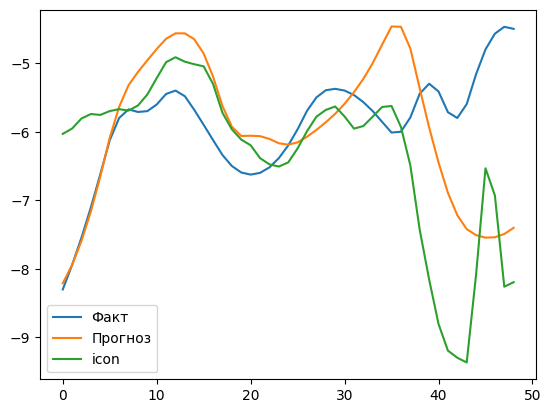

In [198]:
plot_lines('icon', X_test, y_test, predicted, n=-20)

In [ ]:
------ICON-------
--МОДЕЛЬ-ФАКТ ТЕСТОВАЯ ВЫБОРКА:--
r2_score: 0.9800398567005048
mean_absolute_error: 0.885725259580755
mean_squared_error: 1.694087906555642
median_absolute_error: 0.686079677571791
--ICON-ФАКТ ВАЛИДАЦИОННАЯ ВЫБОРКА:--
r2_score: 0.9661980205249915
mean_absolute_error: 1.1614954217899776
mean_squared_error: 2.442612084224439
median_absolute_error: 0.9066981735254047
--ICON-ФАКТ ИСХОДНЫЙ НАБОР:--
r2_score: 0.9657465744629846
mean_absolute_error: 1.1758912876595267
mean_squared_error: 2.505781892815103
median_absolute_error: 0.9218661602207421
--ICON-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--
r2_score: 0.9722779731899203
mean_absolute_error: 1.0354491102446066
mean_squared_error: 1.8910360888452233
median_absolute_error: 0.8350624467783518
--МОДЕЛЬ-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--
r2_score: 0.9870190420487645
mean_absolute_error: 0.6731100544029257
mean_squared_error: 0.9406956585693305
median_absolute_error: 0.522411556343

In [ ]:
------GFS-------
--МОДЕЛЬ-ФАКТ ТЕСТОВАЯ ВЫБОРКА:--
r2_score: 0.974115817620212
mean_absolute_error: 1.0365862389525036
mean_squared_error: 2.2526181512713856
median_absolute_error: 0.8003462139446963
--GFS-ФАКТ ВАЛИДАЦИОННАЯ ВЫБОРКА:--
r2_score: 0.9422923943276582
mean_absolute_error: 1.5250134228014345
mean_squared_error: 4.376422378602904
median_absolute_error: 1.1393435817333448
--GFS-ФАКТ ИСХОДНЫЙ НАБОР:--
r2_score: 0.9431820283051436
mean_absolute_error: 1.5349198016328767
mean_squared_error: 4.412663889628042
median_absolute_error: 1.15294715929674
--GFS-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--
r2_score: 0.9532993122319553
mean_absolute_error: 1.36055671278909
mean_squared_error: 3.361935656154776
median_absolute_error: 1.0522933835885848
--МОДЕЛЬ-ФАКТ ТРЕНИРОВОЧНЫЙ НАБОР:--
r2_score: 0.9805308392963986
mean_absolute_error: 0.8492432021585079
mean_squared_error: 1.4805154337536244
median_absolute_error: 0.6746235438839909

# Запуск процесса формирования прогноза на дату

In [181]:
def forecast_run(forecast_model, forecast_date):
    # Сформировать датасеты
    
    # Обновить датасеты если разница более 48 часов с текущей датой
    ds_date_time = read_last_date_file(forecast_model)
    print(ds_date_time)
    now_date_time = datetime.utcnow()
    print(now_date_time)
    time_dif = now_date_time - ds_date_time
    print('time_dif.days:', time_dif.days)
    if time_dif.days >= 2:    
        update_datasets(forecast_model, z=48)
    
    # Обучить модели и записать в виде файлов на дату
    arg_datetime = datetime.strptime(forecast_date, '%d-%m-%Y')
    train_datetime = arg_datetime - timedelta(hours=48)
    train_date_str = datetime.strftime(train_datetime, '%d-%m-%Y')
    train_models(forecast_model, train_date_str)
    
    # Сделать прогноз и записать в БД на дату 
    write_forecast_to_db(forecast_model, forecast_date)

In [209]:
forecast_run('gfs', '24-01-2024')

2024-02-13 00:00:00
2024-02-15 15:35:41.319457
time_dif.days: 2
1 day, 18:35:41.902382
Прервано - для даты 2024-02-14 00:00:00 не хватит фактических данных!
damaged_rows: []
forecast_X, fact_y len: 0 0
Прервано - для даты 2024-02-14 00:00:00 не хватит фактических данных!
train_models
374
374
get_xy1
374
374
get_xy2
(374, 49)
(374, 17)
(490, 49) (490, 49)


F:\ruslan\projects\forecaster\env_fcr\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2412: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.4918084249293, tolerance: 21.090904332591975
  ) = cd_fast.enet_coordinate_descent_multi_task(


0.9812099476365657
r2_score: 0.9812099476365657
mean_absolute_error: 0.8576519309362466
mean_squared_error: 1.5340504770084389
median_absolute_error: 0.6758403716575396
[[ 7.810e-01  7.570e-01  7.810e-01  8.370e-01  8.070e-01  1.046e+00
   8.800e-01  4.960e-01  5.100e-01  5.620e-01  5.400e-01  5.260e-01
   3.980e-01  8.900e-02  1.000e-03 -1.110e-01 -2.320e-01 -1.430e-01
   2.380e-01  6.800e-01  1.409e+00  1.787e+00  1.946e+00  2.041e+00
   1.785e+00  1.674e+00  1.510e+00  1.449e+00  1.417e+00  1.573e+00
   1.199e+00  8.770e-01  9.180e-01  8.200e-01  7.590e-01  6.420e-01
   5.440e-01  5.650e-01  6.070e-01  6.470e-01  4.610e-01  1.490e-01
   1.200e-02  6.800e-02  1.200e-01 -5.800e-02 -4.110e-01 -4.990e-01
  -5.310e-01]]
49
GTS DATA:
[(2.0,), (2.2,), (2.0,), (1.7,), (1.3,), (0.5,), (0.6,), (2.0,), (2.7,), (3.3,), (3.0,), (2.7,), (2.0,), (0.9,), (0.5,), (0.8,), (0.9,)]
gfs_2024-01-22-00.bin
Model date 22-01-2024


ValueError: X has 54 features, but RobustScaler is expecting 55 features as input.

# Запуск процесса формирования прогноза за период

In [200]:
def forecast_period(forecast_model, start_date, finish_date):
    td = timedelta(hours=24)
    process_datetime = datetime.strptime(start_date, '%d-%m-%Y')
    finish_datetime = datetime.strptime(finish_date, '%d-%m-%Y')
    while process_datetime <= finish_datetime:
        forecast_date = datetime.strftime(process_datetime, '%d-%m-%Y')
        forecast_run(forecast_model, forecast_date)
        print(f'------------------------{forecast_model}: {forecast_date}------------------------------')
        process_datetime += td

In [ ]:
forecast_period('icon', '06-01-2024', '15-02-2024')